# Learning to CIFAR Back!
The CIFAR-10 dataset is a benchmark for computer vision tasks dating to [2009](https://www.cs.toronto.edu/~kriz/cifar.html). We construct a model capable of disentangling an input image created by averaging two random samples from CIFAR-10 and predicting the categories of the two components. We achieve 80% accuracy with an F1 Score of ?. 

This novel task requires training on small datasets (order of 50,000 samples) with small spatial resolution (32x32x3). We overcome this difficulty by eliminating max pooling operations in favor of an All Convolutional Model, inspired by the (second place CIFAR-10 holders)[https://arxiv.org/abs/1412.6806]. The writeup takes the form of a Jupyter notebook, first displaying our most capable model, then chronologically detailing how we arrived to this result.

### 80% Accuracy ACNN3
![ACCN3](ACCN3.png)
### Description
The model has a feature extractor composed purely of two dimensional convolutions. Instead of maxpooling, down sampling the spatial resolution is accomplished by a stride of 2. The extractor reduces the resolution to a stack of 192 2x2 filters. This is flattened and passed to two independent classifiers. They are single layer fully connected layers, with a softmax to produce the 5 possible class probabilities. The network has 20% dropout layers after the stride 2 convolutions to prevent overfitting and no data augmentation, as it did not lead to better results. The standard optimizer has been replaced with [Adagrad](https://keras.io/api/optimizers/adagrad/) which lead to slow but stable convergence. Each classifier has its own cross entropy loss to back propagate through the network, and we observe they do not improve equally, an area for further research on the task.

# Experimental Setup
The reader is invited to train locally by uncommenting the **fit()** calls where indicated.
### Libraries

In [1]:
import tensorflow as tf
import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar10
from tensorflow.nn import fractional_max_pool
from keras.optimizers import Adam
from tensorflow.keras import backend as K
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import os
from tensorflow.keras.callbacks import Callback
from keras.saving import load_model, save_model, save_weights

2025-01-11 09:48:47.677757: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736617727.698840   34466 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736617727.705181   34466 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-11 09:48:47.726231: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Data Preparation

In [2]:
(cifar10_x_train, cifar10_y_train), (cifar10_x_test, cifar10_y_test) = cifar10.load_data()
assert cifar10_x_train.shape == (50000, 32, 32, 3)
assert cifar10_x_test.shape == (10000, 32, 32, 3)
assert cifar10_y_train.shape == (50000, 1)
assert cifar10_y_test.shape == (10000, 1)

# Split part of the training set into validation set
cifar10_x_train, cifar10_x_val, cifar10_y_train, cifar10_y_val = train_test_split(
    cifar10_x_train, cifar10_y_train, test_size=0.1
)

# First classifier: "airplane", "automobile", "bird", "cat", "deer"
# Second classifier: "dog", "frog", "horse", "ship", "truck"
classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

# Normalizing to range (0,1)
cifar10_x_train = (cifar10_x_train/255.).astype(np.float32)
cifar10_x_val = (cifar10_x_val / 255.).astype(np.float32)
cifar10_x_test = (cifar10_x_test/255.).astype(np.float32)

Split the images in two groups, according to their label.

In [3]:
cond_1 = cifar10_y_train[:,0] < 5
cifar10_x_train_1 = cifar10_x_train[cond_1]
cifar10_y_train_1 = cifar10_y_train[cond_1]

cond_2 = cifar10_y_train[:,0] >= 5
cifar10_x_train_2 = cifar10_x_train[cond_2]
cifar10_y_train_2 = cifar10_y_train[cond_2]

cond_1_val = cifar10_y_val[:,0] < 5
cifar10_x_val_1 = cifar10_x_val[cond_1_val]
cifar10_y_val_1 = cifar10_y_val[cond_1_val]

cond_2_val = cifar10_y_val[:,0] >= 5
cifar10_x_val_2 = cifar10_x_val[cond_2_val]
cifar10_y_val_2 = cifar10_y_val[cond_2_val]

cond_1_test = cifar10_y_test[:,0] < 5
cifar10_x_test_1 = cifar10_x_test[cond_1_test]
cifar10_y_test_1 = cifar10_y_test[cond_1_test]

cond_2_test = cifar10_y_test[:,0] >= 5
cifar10_x_test_2 = cifar10_x_test[cond_2_test]
cifar10_y_test_2 = cifar10_y_test[cond_2_test]

Define the generator. The input consists of two datasets (X1,X2), their corresponding labels (Y1,Y2), and a batch size.

The generator returns (x_data,y_data), where:
* x_data is a batch of images obtained by averaging random samples from X1 and X2.
* y_data is a dictionary of batches of labels corresponding to the component images, expressed in categorical format, in other words, one hot encoded.

In [4]:
batchsize = 64

def datagenerator(X1,X2,Y1,Y2,batchsize):
  size1 = X1.shape[0]
  size2 = X2.shape[0]
  Y1_cat = tf.keras.utils.to_categorical(Y1, num_classes=5)
  Y2_cat = tf.keras.utils.to_categorical(Y2-5, num_classes=5)

  while True:
    num1 = np.random.randint(0, size1, batchsize)
    num2 = np.random.randint(0, size2, batchsize)
    x_data = (X1[num1] + X2[num2]) / 2.0
    y_data = {'output1': Y1_cat[num1], 'output2': Y2_cat[num2]}
    yield tf.convert_to_tensor(x_data), y_data

traingen = datagenerator(cifar10_x_train_1,cifar10_x_train_2,cifar10_y_train_1,cifar10_y_train_2,batchsize)
valgen = datagenerator(cifar10_x_val_1,cifar10_x_val_2,cifar10_y_val_1,cifar10_y_val_2,batchsize)
testgen = datagenerator(cifar10_x_test_1,cifar10_x_test_2,cifar10_y_test_1,cifar10_y_test_2,1000)

We generate an example, display the image that the model will take as input, and print the categories of the two overlapping components.

The reader is invited to re-run the cell to display new examples.

first: airplane, second = truck


I0000 00:00:1736617740.388300   34466 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13058 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4080 SUPER, pci bus id: 0000:0a:00.0, compute capability: 8.9


[]

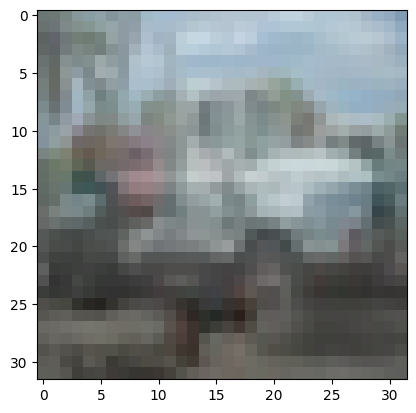

In [5]:
datagen = datagenerator(cifar10_x_train_1,cifar10_x_train_2,cifar10_y_train_1,cifar10_y_train_2,1)
x, y = next(datagen)
print("first: {}, second = {}".format(classes[np.argmax(y['output1'][0])],classes[np.argmax(y['output2'][0])+5]))
plt.imshow(x[0])
plt.plot()

### Model Evaluation
We test our evaluation method with a model which generated random classes.

In [6]:
def random_model():
    inputs = keras.Input(shape=(32,32,3))
    x = layers.Flatten()(inputs)
    output1 = layers.Dense(5, name='output1')(x)
    output2 = layers.Dense(5, name='output2')(x)
    model = keras.Model(
    inputs,
    outputs={'output1':output1, 'output2':output2}, name='Toy',
    )
    model.compile(
    optimizer='Adam', 
    loss={'output1': 'categorical_crossentropy', 'output2': 'categorical_crossentropy'},
    metrics={'output1':'accuracy', 'output2':'accuracy'})
    return model

def evaluate_model(model, gen, repeat=10, steps=10, batchsize=1000):
    evaluation_results = []
    for i in tqdm(range(repeat)):
        results = model.evaluate(gen, batch_size=batchsize, steps=steps, verbose=False, return_dict=True)
        acc1 = results['output1_accuracy']
        acc2 = results['output2_accuracy']
        evaluation_results.append(np.mean([acc1, acc2]))
    print("mean accuracy = ", np.mean(evaluation_results))
    print("standard deviation = ", np.std(evaluation_results))

In [7]:
model = random_model()
evaluate_model(model, testgen)

  0%|          | 0/50 [00:00<?, ?it/s]WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
I0000 00:00:1736617746.400180   34660 service.cc:148] XLA service 0x7f7938004670 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1736617746.400248   34660 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4080 SUPER, Compute Capability 8.9
I0000 00:00:1736617746.452295   34660 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1736617746.878792   34660 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
100%|██████████| 50/50 [00:25<00:00,  1.98it/s]

mean accuracy =  0.1973150008916855
standard deviation =  0.002223358911651219


As expected, the accuracy is around 1/5 = 0.2! We repeat the evaluation ten times, and compute the standard deviation. This is our official project result. We load our top model weights to report. 

In [8]:
model = load_model('ACNN3-85.5.keras')
evaluate_model(model, testgen)

100%|██████████| 10/10 [00:07<00:00,  1.30it/s]

mean accuracy =  0.5209750041365624
standard deviation =  0.0021657860217249303


In [9]:
model = load_model('ACCN1-80.6.keras')
evaluate_model(model, testgen)

100%|██████████| 10/10 [00:04<00:00,  2.11it/s]

mean accuracy =  0.6460500001907349
standard deviation =  0.002171180665960431


In [10]:
model = load_model('ACNN2/0.61-0.72-epoch64-loss1.85.keras')
evaluate_model(model, testgen)

100%|██████████| 10/10 [00:04<00:00,  2.22it/s]

mean accuracy =  0.6572750031948089
standard deviation =  0.0027546531026423804


In [11]:
model = load_model('ACNN/0.64-0.74-epoch39-loss1.43.keras')
evaluate_model(model, testgen)

100%|██████████| 10/10 [00:04<00:00,  2.12it/s]

mean accuracy =  0.6833250015974045
standard deviation =  0.0029996816623369497


### Model Checkpoints
We implement a custom model callback to save the model weights when the average accuracy of both classifiers improves during training. Without this, we would be forced to use a proxy like loss for the metric we care about the most. We use the validation accuracy since it is representative of the unseen data the model will see during testing.

In [12]:
# Custom callback which does not use loss as a proxy!
class MeanAccModelCheckpoint(Callback):
    def __init__(self, filepath, monitor1='val_output1_accuracy', monitor2='val_output2_accuracy', mode='max', verbose=1):
        super(MeanAccModelCheckpoint, self).__init__()
        self.filepath = filepath
        self.monitor1 = monitor1
        self.monitor2 = monitor2
        self.mode = mode
        self.verbose = verbose
        self.best_score = -float('inf') if mode == 'max' else float('inf')

    # Called at the end of an epoch during training
    def on_epoch_end(self, epoch, logs=None):
        acc1 = logs.get(self.monitor1)
        acc2 = logs.get(self.monitor2)

        # Compute the average accuracy
        avg_accuracy = (acc1 + acc2) / 2 if acc1 is not None and acc2 is not None else None

        if avg_accuracy is not None:
            if (self.mode == 'max' and avg_accuracy > self.best_score) or \
               (self.mode == 'min' and avg_accuracy < self.best_score):
                # Update the best score
                self.best_score = avg_accuracy
                
                # Format the filepath
                save_path = self.filepath.format(
                    output1_accuracy=acc1,
                    output2_accuracy=acc2,
                    epoch=epoch + 1,  # Epoch is zero-indexed
                    loss=logs.get('loss')
                )
                
                # Save the model
                if self.verbose:
                    print(f"\nEpoch {epoch + 1}: Average accuracy improved to {avg_accuracy:.4f}, saving model to {save_path}")
                self.model.save(save_path)
            elif self.verbose:
                print(f"\nEpoch {epoch + 1}: Average accuracy did not improve (current: {avg_accuracy:.4f}, best: {self.best_score:.4f})")


We use the built in callback for early stopping so we do not have to worry about training for too few or too many epochs. When the validation loss stops decreasing, the model will try ten more times to improve or revert to the best weights. The validation loss metric is an average of the validation losses of each one of the two classifiers.

In [13]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',  # Track the validation loss
                               patience=10,         # Number of epochs to wait after the last improvement
                               mode='min',         # Stop when the value stops decreasing (minimization)
                               restore_best_weights=True,  # Restore the best weights when stopping
                               verbose=1)

### Model Creation
We use the Keras Functional API to create our model.

In [14]:
def ACCN4():
    # CIFAR-10
    inputs = keras.Input(shape=(32,32,3))
    # Feature Extractor
    x = layers.Conv2D(96, (3,3), activation='relu')(inputs)
    x = layers.Conv2D(96, (3,3), activation='relu')(x)
    x = layers.Conv2D(96, (3,3), activation='relu', strides=2)(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Conv2D(192, (3,3), activation='relu')(x)
    x = layers.Conv2D(192, (3,3), activation='relu')(x)
    x = layers.Conv2D(192, (3,3), activation='relu', strides=2)(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Conv2D(192, (3,3), activation='relu')(x)
    x = layers.Conv2D(192, (1,1), activation='relu')(x)
    # Classifers
    x = layers.Flatten()(x)
    output1 = layers.Dense(5, activation='softmax', name='output1')(x)
    output2 = layers.Dense(5, activation='softmax', name='output2')(x)
    # Model creation
    model = keras.Model(
        inputs,
        outputs={'output1':output1, 'output2':output2}, name='ACCN3',
        )
    return model

In [15]:
K.clear_session() # garbage collection
model = ACCN4()
model.compile(optimizer='adagrad',
              loss={'output1': 'categorical_crossentropy', 'output2': 'categorical_crossentropy'},
              metrics={'output1': 'accuracy', 'output2': 'accuracy'})
model.summary()
history = model.fit(
    traingen,            
    epochs=250,          
    steps_per_epoch=len(cifar10_x_train)//batchsize, # necessary since generator loops infinitely
    validation_data=valgen,
    validation_steps=len(cifar10_x_val)//batchsize,  # necessary since generator loops infinitely
    callbacks=[early_stopping],
    verbose=1
)

Model: "ACCN3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 30, 30,    │      2,688 │ input_layer[0][0] │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 28, 28,    │     83,040 │ conv2d[0][0]      │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 13, 13,    │     83,040 │ conv2d_1[0][0]    │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 13, 13,    │          0 │ conv2d_2[0][0]    │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 11, 11,    │    166,080 │ dropout[0][0]     │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 9, 9, 192) │    331,968 │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 4, 4, 192) │    331,968 │ conv2d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 4, 4, 192) │          0 │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 2, 2, 192) │    331,968 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 2, 2, 192) │     37,056 │ conv2d_6[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 768)       │          0 │ conv2d_7[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output1 (Dense)     │ (None, 5)         │      3,845 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output2 (Dense)     │ (None, 5)         │      3,845 │ flatten[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,375,498 (5.25 MB)

 Trainable params: 1,375,498 (5.25 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/250
703/703 ━━━━━━━━━━━━━━━━━━━━ 15s 13ms/step - loss: 3.2188 - output1_accuracy: 0.2030 - output1_loss: 1.6094 - output2_accuracy: 0.2106 - output2_loss: 1.6094 - val_loss: 3.2175 - val_output1_accuracy: 0.2234 - val_output1_loss: 1.6091 - val_output2_accuracy: 0.2738 - val_output2_loss: 1.6084
Epoch 2/250
703/703 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 3.2171 - output1_accuracy: 0.2218 - output1_loss: 1.6088 - output2_accuracy: 0.2287 - output2_loss: 1.6082 - val_loss: 3.2150 - val_output1_accuracy: 0.2658 - val_output1_loss: 1.6079 - val_output2_accuracy: 0.1999 - val_output2_loss: 1.6070
Epoch 3/250
703/703 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 3.2140 - output1_accuracy: 0.2428 - output1_loss: 1.6077 - output2_accuracy: 0.2074 - output2_loss: 1.6063 - val_loss: 3.2080 - val_output1_accuracy: 0.2678 - val_output1_loss: 1.6049 - val_output2_accuracy: 0.2194 - val_output2_loss: 1.6031
Epoch 4/250
703/703 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 3.2008 - output1_accuracy

In [16]:
evaluate_model(model, testgen)

100%|██████████| 10/10 [00:04<00:00,  2.15it/s]

mean accuracy =  0.5425950020551682
standard deviation =  0.0032745561629200746


In [43]:
def ACCN():
    # CIFAR-10
    inputs = keras.Input(shape=(32,32,3))
    #inputs = layers.RandomFlip("horizontal")(inputs)
    # Feature Extractor
    x = layers.Conv2D(96, (3,3), activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(96, (3,3), activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(96, (3,3), activation='relu', strides=2)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(192, (3,3), activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(192, (3,3), activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(192, (3,3), activation='relu', strides=2)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(192, (3,3), activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(192, (1,1), activation='relu')(x)
    x = layers.BatchNormalization()(x)
    # Classifers
    x = layers.GlobalAveragePooling2D()(x)
    #x = layers.Flatten()(x)
    output1 = layers.Dense(5, activation='softmax', name='output1')(x)
    output2 = layers.Dense(5, activation='softmax', name='output2')(x)
    # Model creation
    model = keras.Model(
        inputs,
        outputs={'output1':output1, 'output2':output2}, name='ACCN',
        )
    return model

In [44]:
K.clear_session() # garbage collection
model = ACCN()
model.compile(optimizer='rmsprop',
              loss={'output1': keras.losses.CategoricalCrossentropy(label_smoothing=0.1), 'output2': keras.losses.CategoricalCrossentropy(label_smoothing=0.1)},
              metrics={'output1': 'accuracy', 'output2': 'accuracy'})
model.summary()
history = model.fit(
    traingen,            
    epochs=250,          
    steps_per_epoch=len(cifar10_x_train)//batchsize, # necessary since generator loops infinitely
    validation_data=valgen,
    validation_steps=len(cifar10_x_val)//batchsize,  # necessary since generator loops infinitely
    callbacks=[early_stopping],
    verbose=1
)

Model: "ACCN"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 30, 30,    │      2,688 │ input_layer[0][0] │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 30, 30,    │        384 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 28, 28,    │     83,040 │ batch_normalizat… │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        384 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 13, 13,    │     83,040 │ batch_normalizat… │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 13, 13,    │        384 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 11, 11,    │    166,080 │ batch_normalizat… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 11, 11,    │        768 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 9, 9, 192) │    331,968 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 9, 9, 192) │        768 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 4, 4, 192) │    331,968 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4, 4, 192) │        768 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 2, 2, 192) │    331,968 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 2, 2, 192) │        768 │ conv2d_6[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 2, 2, 192) │     37,056 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 2, 2, 192) │        768 │ conv2d_7[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 192)       │          0 │ batch_normalizat… │
│ (GlobalAveragePool… │                   │            │                 

 Total params: 1,374,730 (5.24 MB)

 Trainable params: 1,372,234 (5.23 MB)

 Non-trainable params: 2,496 (9.75 KB)

Epoch 1/250
703/703 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - loss: 2.9636 - output1_accuracy: 0.3880 - output1_loss: 1.5019 - output2_accuracy: 0.4188 - output2_loss: 1.4617 - val_loss: 2.7082 - val_output1_accuracy: 0.4233 - val_output1_loss: 1.4208 - val_output2_accuracy: 0.5280 - val_output2_loss: 1.2874
Epoch 2/250
703/703 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 2.4176 - output1_accuracy: 0.5089 - output1_loss: 1.2855 - output2_accuracy: 0.6121 - output2_loss: 1.1321 - val_loss: 2.4614 - val_output1_accuracy: 0.4850 - val_output1_loss: 1.3249 - val_output2_accuracy: 0.6084 - val_output2_loss: 1.1365
Epoch 3/250
703/703 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 2.2226 - output1_accuracy: 0.5649 - output1_loss: 1.1966 - output2_accuracy: 0.6745 - output2_loss: 1.0260 - val_loss: 2.4530 - val_output1_accuracy: 0.4904 - val_output1_loss: 1.3271 - val_output2_accuracy: 0.6272 - val_output2_loss: 1.1259
Epoch 4/250
703/703 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 2.1361 - output1_accuracy

In [45]:
evaluate_model(model, testgen)

  0%|          | 0/10 [00:00<?, ?it/s]2025-01-11 10:50:04.735908: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot', 240 bytes spill stores, 240 bytes spill loads

100%|██████████| 10/10 [00:06<00:00,  1.46it/s]

mean accuracy =  0.7378099918365478
standard deviation =  0.002947435931252253


In [46]:
model.save('73.7acc.keras')

In [47]:
from tensorflow.keras.optimizers import RMSprop

# Custom small learning rate
learning_rate = 1e-5  # You can adjust this value as needed for fine-tuning

# Compile model with RMSprop optimizer and label smoothing for the loss
model.compile(optimizer=RMSprop(learning_rate=learning_rate),
              loss={'output1': keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
                    'output2': keras.losses.CategoricalCrossentropy(label_smoothing=0.1)},
              metrics={'output1': 'accuracy', 'output2': 'accuracy'})

history = model.fit(
    traingen,            
    epochs=250,          
    steps_per_epoch=len(cifar10_x_train)//batchsize, # necessary since generator loops infinitely
    validation_data=valgen,
    validation_steps=len(cifar10_x_val)//batchsize,  # necessary since generator loops infinitely
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/250
703/703 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - loss: 1.4546 - output1_accuracy: 0.8030 - output1_loss: 0.7910 - output2_accuracy: 0.8693 - output2_loss: 0.6636 - val_loss: 1.7747 - val_output1_accuracy: 0.7071 - val_output1_loss: 0.9820 - val_output2_accuracy: 0.8059 - val_output2_loss: 0.7927
Epoch 2/250
703/703 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 1.4325 - output1_accuracy: 0.8118 - output1_loss: 0.7723 - output2_accuracy: 0.8720 - output2_loss: 0.6602 - val_loss: 1.7696 - val_output1_accuracy: 0.7031 - val_output1_loss: 0.9653 - val_output2_accuracy: 0.8047 - val_output2_loss: 0.8043
Epoch 3/250
703/703 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 1.4255 - output1_accuracy: 0.8118 - output1_loss: 0.7753 - output2_accuracy: 0.8774 - output2_loss: 0.6502 - val_loss: 1.7639 - val_output1_accuracy: 0.7073 - val_output1_loss: 0.9700 - val_output2_accuracy: 0.8021 - val_output2_loss: 0.7939
Epoch 4/250
703/703 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 1.4214 - output1_accuracy

In [48]:
evaluate_model(model, testgen)

100%|██████████| 10/10 [00:06<00:00,  1.51it/s]

mean accuracy =  0.7620449990034104
standard deviation =  0.0027785288122172164


In [49]:
model.save('76.2acc.keras')

In [53]:
# Custom small learning rate
learning_rate = 1e-7 # You can adjust this value as needed for fine-tuning

# Compile model with RMSprop optimizer and label smoothing for the loss
model.compile(optimizer='adagrad',
              loss={'output1': keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
                    'output2': keras.losses.CategoricalCrossentropy(label_smoothing=0.1)},
              metrics={'output1': 'accuracy', 'output2': 'accuracy'})

history = model.fit(
    traingen,            
    epochs=250,          
    steps_per_epoch=len(cifar10_x_train)//batchsize, # necessary since generator loops infinitely
    validation_data=valgen,
    validation_steps=len(cifar10_x_val)//batchsize,  # necessary since generator loops infinitely
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/250
703/703 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - loss: 1.3996 - output1_accuracy: 0.8182 - output1_loss: 0.7606 - output2_accuracy: 0.8823 - output2_loss: 0.6390 - val_loss: 1.7521 - val_output1_accuracy: 0.7173 - val_output1_loss: 0.9571 - val_output2_accuracy: 0.8025 - val_output2_loss: 0.7950
Epoch 2/250
703/703 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 1.4034 - output1_accuracy: 0.8239 - output1_loss: 0.7555 - output2_accuracy: 0.8791 - output2_loss: 0.6480 - val_loss: 1.7386 - val_output1_accuracy: 0.7137 - val_output1_loss: 0.9600 - val_output2_accuracy: 0.8135 - val_output2_loss: 0.7786
Epoch 3/250
703/703 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 1.4068 - output1_accuracy: 0.8209 - output1_loss: 0.7576 - output2_accuracy: 0.8804 - output2_loss: 0.6492 - val_loss: 1.7251 - val_output1_accuracy: 0.7145 - val_output1_loss: 0.9411 - val_output2_accuracy: 0.8103 - val_output2_loss: 0.7840
Epoch 4/250
703/703 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 1.3956 - output1_accuracy

In [54]:
evaluate_model(model, testgen)

100%|██████████| 10/10 [00:06<00:00,  1.48it/s]

mean accuracy =  0.7644650042057037
standard deviation =  0.0022757387857020393


In [55]:
model.save('76.4acc.keras')

In [56]:
def ACCNR():
    # CIFAR-10
    inputs = keras.Input(shape=(32,32,3))
    inputs = layers.RandomFlip("horizontal")(inputs)
    # Feature Extractor
    x = layers.Conv2D(96, (3,3), activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(96, (3,3), activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(96, (3,3), activation='relu', strides=2)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(192, (3,3), activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(192, (3,3), activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(192, (3,3), activation='relu', strides=2)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(192, (3,3), activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(192, (1,1), activation='relu')(x)
    x = layers.BatchNormalization()(x)
    # Classifers
    x = layers.GlobalAveragePooling2D()(x)
    #x = layers.Flatten()(x)
    output1 = layers.Dense(5, activation='softmax', name='output1')(x)
    output2 = layers.Dense(5, activation='softmax', name='output2')(x)
    # Model creation
    model = keras.Model(
        inputs,
        outputs={'output1':output1, 'output2':output2}, name='ACCNR',
        )
    return model

In [57]:
K.clear_session() # garbage collection
model = ACCNR()
model.compile(optimizer='rmsprop',
              loss={'output1': keras.losses.CategoricalCrossentropy(label_smoothing=0.1), 'output2': keras.losses.CategoricalCrossentropy(label_smoothing=0.1)},
              metrics={'output1': 'accuracy', 'output2': 'accuracy'})
model.summary()
history = model.fit(
    traingen,            
    epochs=250,          
    steps_per_epoch=len(cifar10_x_train)//batchsize, # necessary since generator loops infinitely
    validation_data=valgen,
    validation_steps=len(cifar10_x_val)//batchsize,  # necessary since generator loops infinitely
    callbacks=[early_stopping],
    verbose=1
)

Model: "ACCNR"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ keras_tensor_1CLONE │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 30, 30,    │      2,688 │ keras_tensor_1CL… │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 30, 30,    │        384 │ conv2d[1][0]      │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 28, 28,    │     83,040 │ batch_normalizat… │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        384 │ conv2d_1[1][0]    │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 13, 13,    │     83,040 │ batch_normalizat… │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 13, 13,    │        384 │ conv2d_2[1][0]    │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 11, 11,    │    166,080 │ batch_normalizat… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 11, 11,    │        768 │ conv2d_3[1][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 9, 9, 192) │    331,968 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 9, 9, 192) │        768 │ conv2d_4[1][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 4, 4, 192) │    331,968 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4, 4, 192) │        768 │ conv2d_5[1][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 2, 2, 192) │    331,968 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 2, 2, 192) │        768 │ conv2d_6[1][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 2, 2, 192) │     37,056 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 2, 2, 192) │        768 │ conv2d_7[1][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 192)       │          0 │ batch_normalizat… │
│ (GlobalAveragePool… │                   │            │                 

 Total params: 1,374,730 (5.24 MB)

 Trainable params: 1,372,234 (5.23 MB)

 Non-trainable params: 2,496 (9.75 KB)

Epoch 1/250
703/703 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - loss: 2.9606 - output1_accuracy: 0.3894 - output1_loss: 1.5017 - output2_accuracy: 0.4277 - output2_loss: 1.4589 - val_loss: 2.7054 - val_output1_accuracy: 0.4345 - val_output1_loss: 1.4062 - val_output2_accuracy: 0.5254 - val_output2_loss: 1.2992
Epoch 2/250
703/703 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 2.4157 - output1_accuracy: 0.5137 - output1_loss: 1.2839 - output2_accuracy: 0.6157 - output2_loss: 1.1319 - val_loss: 2.5296 - val_output1_accuracy: 0.4830 - val_output1_loss: 1.3551 - val_output2_accuracy: 0.5811 - val_output2_loss: 1.1745
Epoch 3/250
703/703 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 2.2331 - output1_accuracy: 0.5686 - output1_loss: 1.1978 - output2_accuracy: 0.6686 - output2_loss: 1.0353 - val_loss: 2.5885 - val_output1_accuracy: 0.4587 - val_output1_loss: 1.3796 - val_output2_accuracy: 0.5663 - val_output2_loss: 1.2089
Epoch 4/250
703/703 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 2.1317 - output1_accuracy

In [58]:
evaluate_model(model, testgen)

100%|██████████| 10/10 [00:13<00:00,  1.34s/it]

mean accuracy =  0.744294998049736
standard deviation =  0.002647495965331791


In [59]:
# Custom small learning rate
learning_rate = 1e-5  # You can adjust this value as needed for fine-tuning

# Compile model with RMSprop optimizer and label smoothing for the loss
model.compile(optimizer=RMSprop(learning_rate=learning_rate),
              loss={'output1': keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
                    'output2': keras.losses.CategoricalCrossentropy(label_smoothing=0.1)},
              metrics={'output1': 'accuracy', 'output2': 'accuracy'})

history = model.fit(
    traingen,            
    epochs=250,          
    steps_per_epoch=len(cifar10_x_train)//batchsize, # necessary since generator loops infinitely
    validation_data=valgen,
    validation_steps=len(cifar10_x_val)//batchsize,  # necessary since generator loops infinitely
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/250
703/703 ━━━━━━━━━━━━━━━━━━━━ 17s 13ms/step - loss: 1.4750 - output1_accuracy: 0.7917 - output1_loss: 0.8013 - output2_accuracy: 0.8653 - output2_loss: 0.6737 - val_loss: 1.7586 - val_output1_accuracy: 0.7079 - val_output1_loss: 0.9746 - val_output2_accuracy: 0.8063 - val_output2_loss: 0.7840
Epoch 2/250
703/703 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 1.4559 - output1_accuracy: 0.8002 - output1_loss: 0.7922 - output2_accuracy: 0.8706 - output2_loss: 0.6637 - val_loss: 1.7576 - val_output1_accuracy: 0.7115 - val_output1_loss: 0.9623 - val_output2_accuracy: 0.7977 - val_output2_loss: 0.7953
Epoch 3/250
703/703 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 1.4420 - output1_accuracy: 0.8081 - output1_loss: 0.7799 - output2_accuracy: 0.8706 - output2_loss: 0.6621 - val_loss: 1.7502 - val_output1_accuracy: 0.7115 - val_output1_loss: 0.9603 - val_output2_accuracy: 0.8015 - val_output2_loss: 0.7899
Epoch 4/250
703/703 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 1.4448 - output1_accuracy

In [60]:
evaluate_model(model, testgen)

100%|██████████| 10/10 [00:12<00:00,  1.28s/it]

mean accuracy =  0.7637950003147125
standard deviation =  0.0028752839783437894


In [65]:
# Custom small learning rate
learning_rate = 1e-5  # You can adjust this value as needed for fine-tuning

# Compile model with RMSprop optimizer and label smoothing for the loss
model.compile(optimizer='adam',
              loss={'output1': keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
                    'output2': keras.losses.CategoricalCrossentropy(label_smoothing=0.1)},
              metrics={'output1': 'accuracy', 'output2': 'accuracy'})

history = model.fit(
    traingen,            
    epochs=250,          
    steps_per_epoch=len(cifar10_x_train)//batchsize, # necessary since generator loops infinitely
    validation_data=valgen,
    validation_steps=len(cifar10_x_val)//batchsize,  # necessary since generator loops infinitely
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/250
703/703 ━━━━━━━━━━━━━━━━━━━━ 19s 14ms/step - loss: 1.4774 - output1_accuracy: 0.7957 - output1_loss: 0.8000 - output2_accuracy: 0.8639 - output2_loss: 0.6774 - val_loss: 1.8565 - val_output1_accuracy: 0.6875 - val_output1_loss: 1.0168 - val_output2_accuracy: 0.7821 - val_output2_loss: 0.8397
Epoch 2/250
703/703 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 1.4984 - output1_accuracy: 0.7888 - output1_loss: 0.8117 - output2_accuracy: 0.8598 - output2_loss: 0.6867 - val_loss: 1.8383 - val_output1_accuracy: 0.6945 - val_output1_loss: 0.9821 - val_output2_accuracy: 0.7688 - val_output2_loss: 0.8562
Epoch 3/250
703/703 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 1.4799 - output1_accuracy: 0.7961 - output1_loss: 0.7988 - output2_accuracy: 0.8608 - output2_loss: 0.6811 - val_loss: 1.8162 - val_output1_accuracy: 0.6975 - val_output1_loss: 0.9789 - val_output2_accuracy: 0.7867 - val_output2_loss: 0.8373
Epoch 4/250
703/703 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 1.4774 - output1_accuracy

In [66]:
evaluate_model(model, testgen)

100%|██████████| 10/10 [00:12<00:00,  1.21s/it]

mean accuracy =  0.7420600026845932
standard deviation =  0.003503768097391289


In [73]:
from tensorflow.keras import regularizers

def ACCNRR():
    # CIFAR-10
    inputs = keras.Input(shape=(32,32,3))
    inputs = layers.RandomFlip("horizontal")(inputs)
    #inputs = layers.RandomTranslation(height_factor=5/32, width_factor=5/32, fill_mode='nearest')(inputs)
    # Feature Extractor
    x = layers.Conv2D(96, (3,3), activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(96, (3,3), activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(96, (3,3), activation='relu', strides=2)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(192, (3,3), activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(192, (3,3), activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(192, (3,3), activation='relu', strides=2)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(192, (3,3), activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(192, (1,1), activation='relu')(x)
    x = layers.BatchNormalization()(x)
    # Classifers
    x = layers.GlobalAveragePooling2D()(x)
    #x = layers.Flatten()(x)
    output1 = layers.Dense(5, activation='softmax', name='output1', kernel_regularizer=regularizers.l2(0.01))(x)
    output2 = layers.Dense(5, activation='softmax', name='output2', kernel_regularizer=regularizers.l2(0.01))(x)
    # Model creation
    model = keras.Model(
        inputs,
        outputs={'output1':output1, 'output2':output2}, name='ACCNRR',
        )
    return model

In [74]:
K.clear_session() # garbage collection
model = ACCNRR()
model.compile(optimizer='rmsprop',
              loss={'output1': keras.losses.CategoricalCrossentropy(label_smoothing=0.1), 'output2': keras.losses.CategoricalCrossentropy(label_smoothing=0.1)},
              metrics={'output1': 'accuracy', 'output2': 'accuracy'})
model.summary()
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.000001)
history = model.fit(
    traingen,            
    epochs=250,          
    steps_per_epoch=len(cifar10_x_train)//batchsize, # necessary since generator loops infinitely
    validation_data=valgen,
    validation_steps=len(cifar10_x_val)//batchsize,  # necessary since generator loops infinitely
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Model: "ACCNRR"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ keras_tensor_1CLONE │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 30, 30,    │      2,688 │ keras_tensor_1CL… │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 30, 30,    │        384 │ conv2d[1][0]      │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 28, 28,    │     83,040 │ batch_normalizat… │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        384 │ conv2d_1[1][0]    │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 13, 13,    │     83,040 │ batch_normalizat… │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 13, 13,    │        384 │ conv2d_2[1][0]    │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 11, 11,    │    166,080 │ batch_normalizat… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 11, 11,    │        768 │ conv2d_3[1][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 9, 9, 192) │    331,968 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 9, 9, 192) │        768 │ conv2d_4[1][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 4, 4, 192) │    331,968 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4, 4, 192) │        768 │ conv2d_5[1][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 2, 2, 192) │    331,968 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 2, 2, 192) │        768 │ conv2d_6[1][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 2, 2, 192) │     37,056 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 2, 2, 192) │        768 │ conv2d_7[1][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 192)       │          0 │ batch_normalizat… │
│ (GlobalAveragePool… │                   │            │                 

 Total params: 1,374,730 (5.24 MB)

 Trainable params: 1,372,234 (5.23 MB)

 Non-trainable params: 2,496 (9.75 KB)

Epoch 1/250
703/703 ━━━━━━━━━━━━━━━━━━━━ 17s 13ms/step - loss: 3.0777 - output1_accuracy: 0.3984 - output1_loss: 1.4852 - output2_accuracy: 0.4272 - output2_loss: 1.4491 - val_loss: 3.0848 - val_output1_accuracy: 0.3924 - val_output1_loss: 1.5310 - val_output2_accuracy: 0.4299 - val_output2_loss: 1.4849
Epoch 2/250
703/703 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 2.4576 - output1_accuracy: 0.5138 - output1_loss: 1.2717 - output2_accuracy: 0.6133 - output2_loss: 1.1300 - val_loss: 3.0116 - val_output1_accuracy: 0.4107 - val_output1_loss: 1.5836 - val_output2_accuracy: 0.5054 - val_output2_loss: 1.3981
Epoch 3/250
703/703 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 2.2501 - output1_accuracy: 0.5688 - output1_loss: 1.1965 - output2_accuracy: 0.6711 - output2_loss: 1.0279 - val_loss: 2.4327 - val_output1_accuracy: 0.4992 - val_output1_loss: 1.3186 - val_output2_accuracy: 0.6378 - val_output2_loss: 1.0951
Epoch 4/250
703/703 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 2.1262 - output1_accuracy

In [75]:
evaluate_model(model, testgen)

100%|██████████| 10/10 [00:10<00:00,  1.03s/it]

mean accuracy =  0.7449000000953674
standard deviation =  0.0023437179247066614


In [77]:
model.compile(optimizer='rmsprop',
              loss={'output1': keras.losses.CategoricalCrossentropy(label_smoothing=0.1), 'output2': keras.losses.CategoricalCrossentropy(label_smoothing=0.1)},
              metrics={'output1': 'accuracy', 'output2': 'accuracy'})
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.000001, verbose=1)
history = model.fit(
    traingen,            
    epochs=250,          
    steps_per_epoch=len(cifar10_x_train)//batchsize, # necessary since generator loops infinitely
    validation_data=valgen,
    validation_steps=len(cifar10_x_val)//batchsize,  # necessary since generator loops infinitely
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/250
703/703 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - loss: 1.3606 - output1_accuracy: 0.8392 - output1_loss: 0.7224 - output2_accuracy: 0.8925 - output2_loss: 0.6264 - val_loss: 1.9467 - val_output1_accuracy: 0.6605 - val_output1_loss: 1.0716 - val_output2_accuracy: 0.7730 - val_output2_loss: 0.8633 - learning_rate: 0.0010
Epoch 2/250
703/703 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 1.3802 - output1_accuracy: 0.8349 - output1_loss: 0.7332 - output2_accuracy: 0.8858 - output2_loss: 0.6354 - val_loss: 1.9080 - val_output1_accuracy: 0.6813 - val_output1_loss: 1.0449 - val_output2_accuracy: 0.7778 - val_output2_loss: 0.8519 - learning_rate: 0.0010
Epoch 3/250
703/703 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 1.3739 - output1_accuracy: 0.8349 - output1_loss: 0.7284 - output2_accuracy: 0.8866 - output2_loss: 0.6341 - val_loss: 1.9518 - val_output1_accuracy: 0.6593 - val_output1_loss: 1.0942 - val_output2_accuracy: 0.7804 - val_output2_loss: 0.8460 - learning_rate: 0.0010
Epoch 4/250
703

In [78]:
evaluate_model(model,testgen)

100%|██████████| 10/10 [00:11<00:00,  1.15s/it]

mean accuracy =  0.7728849947452545
standard deviation =  0.0034772096260280113


In [79]:
model.save('77.2acc.keras')

In [84]:
def ACCNRR2():
    # CIFAR-10
    inputs = keras.Input(shape=(32,32,3))
    #inputs = layers.RandomFlip("horizontal")(inputs)
    #inputs = layers.RandomTranslation(height_factor=5/32, width_factor=5/32, fill_mode='nearest')(inputs)
    # Feature Extractor
    x = layers.Conv2D(96, (3,3), activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(96, (3,3), activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(96, (3,3), activation='relu', strides=2)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(192, (3,3), activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(192, (3,3), activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(192, (3,3), activation='relu', strides=2)(x)
    x = layers.BatchNormalization()(x)
    # x = layers.Conv2D(192, (3,3), activation='relu')(x)
    # x = layers.BatchNormalization()(x)
    # Classifers
    x1 = layers.Conv2D(192, (1,1), activation='relu')(x)
    x1 = layers.BatchNormalization()(x1)
    x1 = layers.GlobalAveragePooling2D()(x1)
    x2 = layers.Conv2D(192, (1,1), activation='relu')(x)
    x2 = layers.BatchNormalization()(x2)
    x2 = layers.GlobalAveragePooling2D()(x2)
    #x = layers.Flatten()(x)
    output1 = layers.Dense(5, activation='softmax', name='output1', kernel_regularizer=regularizers.l2(0.01))(x1)
    output2 = layers.Dense(5, activation='softmax', name='output2', kernel_regularizer=regularizers.l2(0.01))(x2)
    # Model creation
    model = keras.Model(
        inputs,
        outputs={'output1':output1, 'output2':output2}, name='ACCNRR2',
        )
    return model

In [85]:
K.clear_session() # garbage collection
model = ACCNRR2()
model.compile(optimizer='rmsprop',
              loss={'output1': keras.losses.CategoricalCrossentropy(label_smoothing=0.1), 'output2': keras.losses.CategoricalCrossentropy(label_smoothing=0.1)},
              metrics={'output1': 'accuracy', 'output2': 'accuracy'})
model.summary()
model.compile(optimizer='rmsprop',
              loss={'output1': keras.losses.CategoricalCrossentropy(label_smoothing=0.1), 'output2': keras.losses.CategoricalCrossentropy(label_smoothing=0.1)},
              metrics={'output1': 'accuracy', 'output2': 'accuracy'})
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.000001, verbose=1)
history = model.fit(
    traingen,            
    epochs=250,          
    steps_per_epoch=len(cifar10_x_train)//batchsize, # necessary since generator loops infinitely
    validation_data=valgen,
    validation_steps=len(cifar10_x_val)//batchsize,  # necessary since generator loops infinitely
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Model: "ACCNRR2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 30, 30,    │      2,688 │ input_layer[0][0] │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 30, 30,    │        384 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 28, 28,    │     83,040 │ batch_normalizat… │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        384 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 13, 13,    │     83,040 │ batch_normalizat… │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 13, 13,    │        384 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 11, 11,    │    166,080 │ batch_normalizat… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 11, 11,    │        768 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 9, 9, 192) │    331,968 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 9, 9, 192) │        768 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 4, 4, 192) │    331,968 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4, 4, 192) │        768 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 4, 4, 192) │     37,056 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 4, 4, 192) │     37,056 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4, 4, 192) │        768 │ conv2d_6[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4, 4, 192) │        768 │ conv2d_7[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 192)       │          0 │ batch_normalizat… │
│ (GlobalAveragePool… │                   │            │                 

 Total params: 1,079,818 (4.12 MB)

 Trainable params: 1,077,322 (4.11 MB)

 Non-trainable params: 2,496 (9.75 KB)

Epoch 1/250
703/703 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - loss: 3.0003 - output1_accuracy: 0.3958 - output1_loss: 1.4703 - output2_accuracy: 0.4535 - output2_loss: 1.3992 - val_loss: 2.8194 - val_output1_accuracy: 0.3658 - val_output1_loss: 1.4871 - val_output2_accuracy: 0.5164 - val_output2_loss: 1.2903 - learning_rate: 0.0010
Epoch 2/250
703/703 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 2.3907 - output1_accuracy: 0.5291 - output1_loss: 1.2516 - output2_accuracy: 0.6290 - output2_loss: 1.1049 - val_loss: 2.5269 - val_output1_accuracy: 0.4954 - val_output1_loss: 1.3755 - val_output2_accuracy: 0.6222 - val_output2_loss: 1.1302 - learning_rate: 0.0010
Epoch 3/250
703/703 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 2.2353 - output1_accuracy: 0.5688 - output1_loss: 1.1941 - output2_accuracy: 0.6793 - output2_loss: 1.0211 - val_loss: 2.7355 - val_output1_accuracy: 0.4581 - val_output1_loss: 1.4114 - val_output2_accuracy: 0.5469 - val_output2_loss: 1.3048 - learning_rate: 0.0010
Epoch 4/250
703

In [86]:
evaluate_model(model,testgen)

100%|██████████| 10/10 [00:07<00:00,  1.33it/s]

mean accuracy =  0.7608000040054321
standard deviation =  0.0014462036836579227


In [87]:
def ACCNRR3():
    # CIFAR-10
    inputs = keras.Input(shape=(32,32,3))
    # Feature Extractor
    x = layers.Conv2D(96, (3,3), activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(96, (3,3), activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(96, (3,3), activation='relu', strides=2)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(192, (3,3), activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(192, (3,3), activation='relu')(x)
    x = layers.BatchNormalization()(x)
    # Classifers
    x1 = layers.Conv2D(192, (3,3), activation='relu', strides=2)(x)
    x1 = layers.BatchNormalization()(x1)
    x1 = layers.Conv2D(192, (1,1), activation='relu')(x1)
    x1 = layers.BatchNormalization()(x1)
    x1 = layers.GlobalAveragePooling2D()(x1)
    x2 = layers.Conv2D(192, (3,3), activation='relu', strides=2)(x)
    x2 = layers.BatchNormalization()(x2)
    x2 = layers.Conv2D(192, (1,1), activation='relu')(x2)
    x2 = layers.BatchNormalization()(x2)
    x2 = layers.GlobalAveragePooling2D()(x2)
    #x = layers.Flatten()(x)
    output1 = layers.Dense(5, activation='softmax', name='output1', kernel_regularizer=regularizers.l2(0.01))(x1)
    output2 = layers.Dense(5, activation='softmax', name='output2', kernel_regularizer=regularizers.l2(0.01))(x2)
    # Model creation
    model = keras.Model(
        inputs,
        outputs={'output1':output1, 'output2':output2}, name='ACCNRR3',
        )
    return model

In [88]:
K.clear_session() # garbage collection
model = ACCNRR3()
model.compile(optimizer='rmsprop',
              loss={'output1': keras.losses.CategoricalCrossentropy(label_smoothing=0.1), 'output2': keras.losses.CategoricalCrossentropy(label_smoothing=0.1)},
              metrics={'output1': 'accuracy', 'output2': 'accuracy'})
model.summary()
model.compile(optimizer='rmsprop',
              loss={'output1': keras.losses.CategoricalCrossentropy(label_smoothing=0.1), 'output2': keras.losses.CategoricalCrossentropy(label_smoothing=0.1)},
              metrics={'output1': 'accuracy', 'output2': 'accuracy'})
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=1e-9, verbose=1)
history = model.fit(
    traingen,            
    epochs=250,          
    steps_per_epoch=len(cifar10_x_train)//batchsize, # necessary since generator loops infinitely
    validation_data=valgen,
    validation_steps=len(cifar10_x_val)//batchsize,  # necessary since generator loops infinitely
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Model: "ACCNRR3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 30, 30,    │      2,688 │ input_layer[0][0] │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 30, 30,    │        384 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 28, 28,    │     83,040 │ batch_normalizat… │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        384 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 13, 13,    │     83,040 │ batch_normalizat… │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 13, 13,    │        384 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 11, 11,    │    166,080 │ batch_normalizat… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 11, 11,    │        768 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 9, 9, 192) │    331,968 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 9, 9, 192) │        768 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 4, 4, 192) │    331,968 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 4, 4, 192) │    331,968 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4, 4, 192) │        768 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4, 4, 192) │        768 │ conv2d_7[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 4, 4, 192) │     37,056 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 4, 4, 192) │     37,056 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4, 4, 192) │        768 │ conv2d_6[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 1,412,554 (5.39 MB)

 Trainable params: 1,409,674 (5.38 MB)

 Non-trainable params: 2,880 (11.25 KB)

Epoch 1/250
703/703 ━━━━━━━━━━━━━━━━━━━━ 19s 16ms/step - loss: 3.0550 - output1_accuracy: 0.3926 - output1_loss: 1.4776 - output2_accuracy: 0.4317 - output2_loss: 1.4364 - val_loss: 2.6912 - val_output1_accuracy: 0.3962 - val_output1_loss: 1.4266 - val_output2_accuracy: 0.5681 - val_output2_loss: 1.2173 - learning_rate: 0.0010
Epoch 2/250
703/703 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 2.3946 - output1_accuracy: 0.5275 - output1_loss: 1.2529 - output2_accuracy: 0.6273 - output2_loss: 1.1048 - val_loss: 2.7027 - val_output1_accuracy: 0.5032 - val_output1_loss: 1.3021 - val_output2_accuracy: 0.5365 - val_output2_loss: 1.3793 - learning_rate: 0.0010
Epoch 3/250
703/703 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 2.2188 - output1_accuracy: 0.5798 - output1_loss: 1.1796 - output2_accuracy: 0.6786 - output2_loss: 1.0188 - val_loss: 2.3980 - val_output1_accuracy: 0.5397 - val_output1_loss: 1.2643 - val_output2_accuracy: 0.6118 - val_output2_loss: 1.1155 - learning_rate: 0.0010
Epoch 4/250
703

In [89]:
evaluate_model(model,testgen)

100%|██████████| 10/10 [00:07<00:00,  1.34it/s]

mean accuracy =  0.7647300004959107
standard deviation =  0.0036044590901915708


In [90]:
def ACCNRR4():
    # CIFAR-10
    inputs = keras.Input(shape=(32,32,3))
    inputs = layers.RandomFlip("horizontal")(inputs)
    # Feature Extractor
    x = layers.Conv2D(96, (3,3), activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(96, (3,3), activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(96, (3,3), activation='relu', strides=2)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(192, (3,3), activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(192, (3,3), activation='relu')(x)
    x = layers.BatchNormalization()(x)
    # Classifers
    x1 = layers.Conv2D(192, (3,3), activation='relu', strides=2)(x)
    x1 = layers.BatchNormalization()(x1)
    x1 = layers.Conv2D(192, (1,1), activation='relu')(x1)
    x1 = layers.BatchNormalization()(x1)
    x1 = layers.GlobalAveragePooling2D()(x1)
    x2 = layers.Conv2D(192, (3,3), activation='relu', strides=2)(x)
    x2 = layers.BatchNormalization()(x2)
    x2 = layers.Conv2D(192, (1,1), activation='relu')(x2)
    x2 = layers.BatchNormalization()(x2)
    x2 = layers.GlobalAveragePooling2D()(x2)
    #x = layers.Flatten()(x)
    output1 = layers.Dense(5, activation='softmax', name='output1', kernel_regularizer=regularizers.l2(0.01))(x1)
    output2 = layers.Dense(5, activation='softmax', name='output2', kernel_regularizer=regularizers.l2(0.01))(x2)
    # Model creation
    model = keras.Model(
        inputs,
        outputs={'output1':output1, 'output2':output2}, name='ACCNRR4',
        )
    return model

In [92]:
K.clear_session() # garbage collection
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',  # Track the validation loss
                               patience=20,         # Number of epochs to wait after the last improvement
                               mode='min',         # Stop when the value stops decreasing (minimization)
                               restore_best_weights=True,  # Restore the best weights when stopping
                               verbose=1)
model = ACCNRR4()
model.compile(optimizer='rmsprop',
              loss={'output1': keras.losses.CategoricalCrossentropy(label_smoothing=0.2), 'output2': keras.losses.CategoricalCrossentropy(label_smoothing=0.1)},
              metrics={'output1': 'accuracy', 'output2': 'accuracy'})
model.summary()
model.compile(optimizer='rmsprop',
              loss={'output1': keras.losses.CategoricalCrossentropy(label_smoothing=0.2), 'output2': keras.losses.CategoricalCrossentropy(label_smoothing=0.1)},
              metrics={'output1': 'accuracy', 'output2': 'accuracy'})
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=1e-9, verbose=1)
history = model.fit(
    traingen,            
    epochs=250,          
    steps_per_epoch=len(cifar10_x_train)//batchsize, # necessary since generator loops infinitely
    validation_data=valgen,
    validation_steps=len(cifar10_x_val)//batchsize,  # necessary since generator loops infinitely
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Model: "ACCNRR4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ keras_tensor_1CLONE │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 30, 30,    │      2,688 │ keras_tensor_1CL… │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 30, 30,    │        384 │ conv2d[1][0]      │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 28, 28,    │     83,040 │ batch_normalizat… │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        384 │ conv2d_1[1][0]    │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 13, 13,    │     83,040 │ batch_normalizat… │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 13, 13,    │        384 │ conv2d_2[1][0]    │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 11, 11,    │    166,080 │ batch_normalizat… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 11, 11,    │        768 │ conv2d_3[1][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 9, 9, 192) │    331,968 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 9, 9, 192) │        768 │ conv2d_4[1][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 4, 4, 192) │    331,968 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 4, 4, 192) │    331,968 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4, 4, 192) │        768 │ conv2d_5[1][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4, 4, 192) │        768 │ conv2d_7[1][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 4, 4, 192) │     37,056 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 4, 4, 192) │     37,056 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4, 4, 192) │        768 │ conv2d_6[1][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 1,412,554 (5.39 MB)

 Trainable params: 1,409,674 (5.38 MB)

 Non-trainable params: 2,880 (11.25 KB)

Epoch 1/250
703/703 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - loss: 3.0740 - output1_accuracy: 0.3799 - output1_loss: 1.5243 - output2_accuracy: 0.4385 - output2_loss: 1.4133 - val_loss: 3.1164 - val_output1_accuracy: 0.3590 - val_output1_loss: 1.5732 - val_output2_accuracy: 0.4087 - val_output2_loss: 1.5015 - learning_rate: 0.0010
Epoch 2/250
703/703 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 2.4760 - output1_accuracy: 0.5226 - output1_loss: 1.3433 - output2_accuracy: 0.6347 - output2_loss: 1.1008 - val_loss: 2.5771 - val_output1_accuracy: 0.5162 - val_output1_loss: 1.3523 - val_output2_accuracy: 0.5647 - val_output2_loss: 1.2064 - learning_rate: 0.0010
Epoch 3/250
703/703 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 2.3311 - output1_accuracy: 0.5637 - output1_loss: 1.2911 - output2_accuracy: 0.6774 - output2_loss: 1.0228 - val_loss: 2.5407 - val_output1_accuracy: 0.5142 - val_output1_loss: 1.3686 - val_output2_accuracy: 0.5994 - val_output2_loss: 1.1563 - learning_rate: 0.0010
Epoch 4/250
703

In [93]:
evaluate_model(model,testgen)

100%|██████████| 10/10 [00:12<00:00,  1.21s/it]

mean accuracy =  0.7578449964523315
standard deviation =  0.003335145901600307
